In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/df_ajustado.csv')
df.head()

,data,dia_semana,total_uh,uhs_ocupadas,adr,receita,meta_uh_ocupada,meta_adr,meta_receita,occ,meta_occ
0,2022-01-01,Sábado,96,33,186.612727,6158.22,26,175.949804,4575,34.375000,27.083333
1,2022-01-02,Domingo,96,36,183.996667,6623.88,24,175.907304,4222,37.500000,25.000000
2,2022-01-03,Segunda,96,40,193.209500,7728.38,39,176.433651,6881,41.666667,40.625000
3,2022-01-04,Terça,96,46,184.547609,8489.19,43,176.459805,7588,47.916667,44.791667
4,2022-01-05,Quarta,96,54,184.261111,9950.10,43,176.459805,7588,56.250000,44.791667


In [2]:
df = df.drop(columns=['total_uh','uhs_ocupadas', 'receita', 'meta_uh_ocupada', 'meta_adr', 'meta_receita', 'meta_occ'])
df.head()

,data,dia_semana,adr,occ
0,2022-01-01,Sábado,186.612727,34.375000
1,2022-01-02,Domingo,183.996667,37.500000
2,2022-01-03,Segunda,193.209500,41.666667
3,2022-01-04,Terça,184.547609,47.916667
4,2022-01-05,Quarta,184.261111,56.250000


In [3]:
df.to_csv('df.csv', index=False)

In [4]:
is_null = df.isnull().sum()
print(f'valores nulos: {is_null}')

valores nulos: data          0
dia_semana    0
adr           0
occ           0
dtype: int64


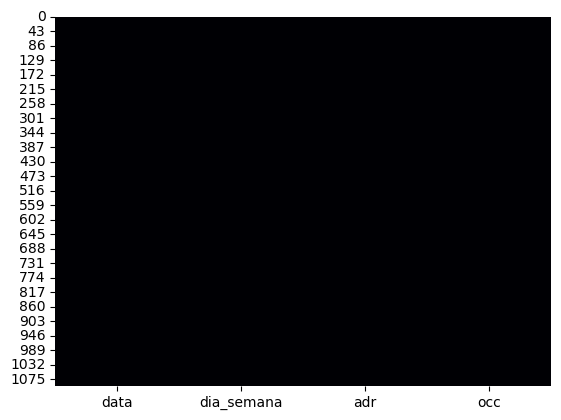

In [5]:
sns.heatmap(df.isnull(),cmap = 'magma',cbar = False);

Distribuição da ADR:

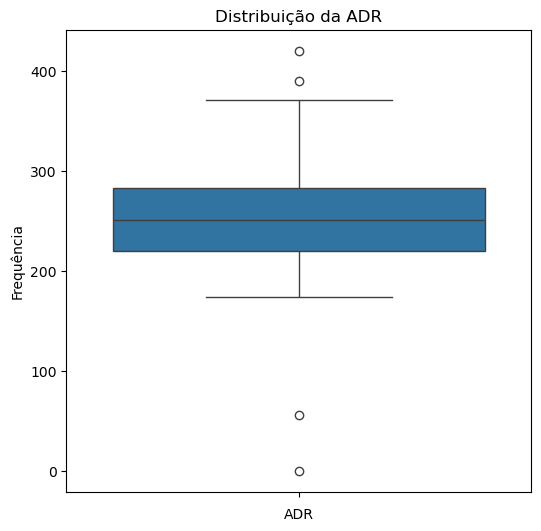

In [7]:
plt.figure(figsize=(6, 6))
sns.boxplot(df['adr'])
plt.title('Distribuição da ADR')
plt.xlabel('ADR')
plt.ylabel('Frequência')
plt.show()

Distribuição da OCC:

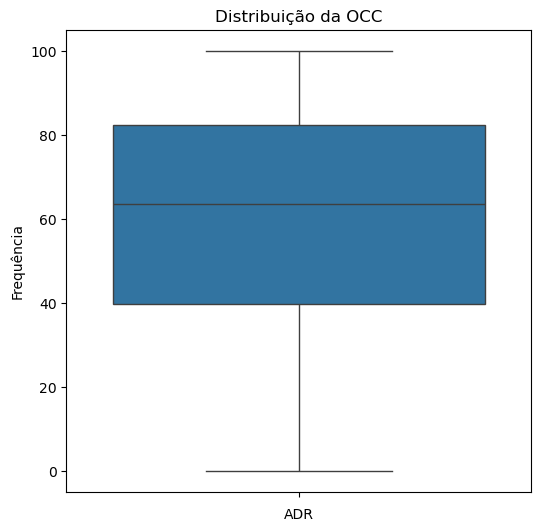

In [9]:
plt.figure(figsize=(6, 6))
sns.boxplot(df['occ'])
plt.title('Distribuição da OCC')
plt.xlabel('ADR')
plt.ylabel('Frequência')
plt.show()

Faremos a normalização dos dados de ADR, pois como esse hotel em questão existe e está em operação, sua ADR não tem como ser zero.
Assim como não existe uma ocupação de O%.

In [11]:
df['adr'].describe()

count    1096.000000
mean      252.715801
std        41.341017
min         0.000000
25%       220.133741
50%       251.232303
75%       283.113438
max       420.685556
Name: adr, dtype: float64

Normalização:

In [13]:
menores = df['adr'].nsmallest(3)
print(menores) # Encontrando os menores valores para retirar o outlier de bug na entrega dos dados.

456       0.000000
1058     55.343043
513     174.099091
Name: adr, dtype: float64


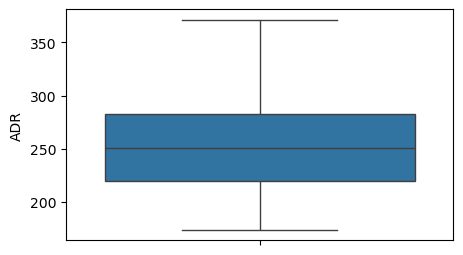

In [14]:
Q1 = df['adr'].quantile(0.25)
Q3 = df['adr'].quantile(0.75)
IQR = Q3 - Q1
df['adr'] = df['adr'].apply(lambda x: np.nan if (x < (Q1 - 1.5 * IQR)) or (x > (Q3 + 1.5 * IQR)) else x)
limite_max = 420
limite_min = 174
df['adr'] = df['adr'].apply(lambda x: limite_max if x > limite_max else (limite_min if x < limite_min else x))

plt.figure(figsize=(5, 3))
sns.boxplot(data = df, y='adr')
plt.ylabel('ADR')
plt.show()

Text(0, 0.5, 'Frequência')

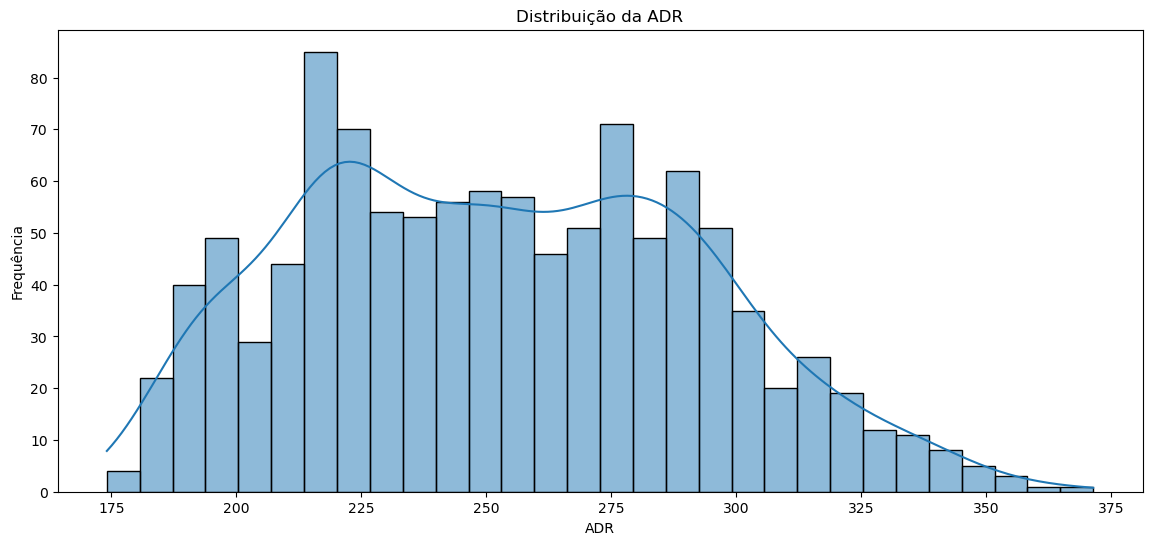

In [15]:
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='adr', bins=30, kde=True)
plt.title('Distribuição da ADR')
plt.xlabel('ADR')
plt.ylabel('Frequência')

Ocupação:

In [17]:
df['occ'].describe()

count    1096.000000
mean       60.415716
std        24.686385
min         0.000000
25%        39.583333
50%        63.541667
75%        82.291667
max       100.000000
Name: occ, dtype: float64

In [18]:
menores = df['occ'].nsmallest(3)
print(menores) # Encontrando os menores valores para retirar o outlier de bug na entrega dos dados.

180    0.000000
953    8.333333
477    9.375000
Name: occ, dtype: float64


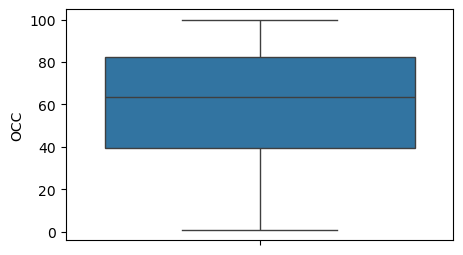

In [19]:
Q1 = df['occ'].quantile(0.25)
Q3 = df['occ'].quantile(0.75)
IQR = Q3 - Q1
df['occ'] = df['occ'].apply(lambda x: np.nan if (x < (Q1 - 1.5 * IQR)) or (x > (Q3 + 1.5 * IQR)) else x)
limite_max = 100
limite_min = 1
df['occ'] = df['occ'].apply(lambda x: limite_max if x > limite_max else (limite_min if x < limite_min else x))

plt.figure(figsize=(5, 3))
sns.boxplot(data = df, y='occ')
plt.ylabel('OCC')
plt.show()

Verificando os valores nulos após a normalização:

In [21]:
df.isnull().sum()

data          0
dia_semana    0
adr           4
occ           0
dtype: int64

Interpolando esses valores nulos:

In [23]:
adr_null = df['adr'].isnull().sum()
if adr_null > 0:
    df['adr'] = df['adr'].interpolate()
    print("Interpolamos os valores faltantes em 'adr'.")

Interpolamos os valores faltantes em 'adr'.


Visualizando a ADR ao longo do tempo:

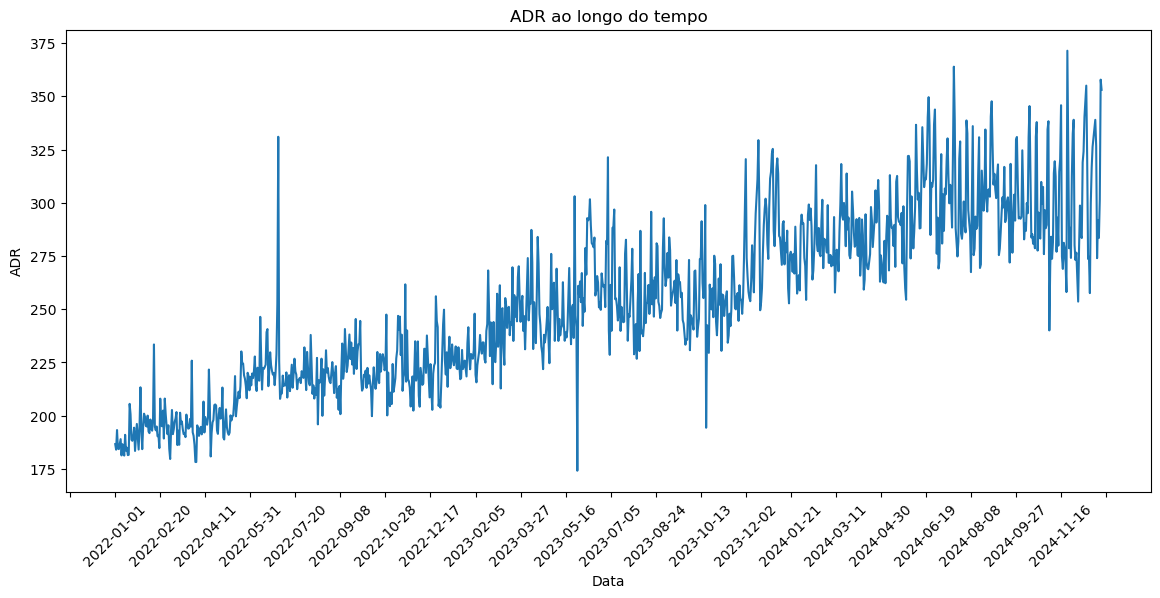

In [25]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='data', y='adr')
plt.title('ADR ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('ADR')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=30))
plt.xticks(rotation=45)
plt.show()

Média de ocupação por dia de semana ao longo dos anos:

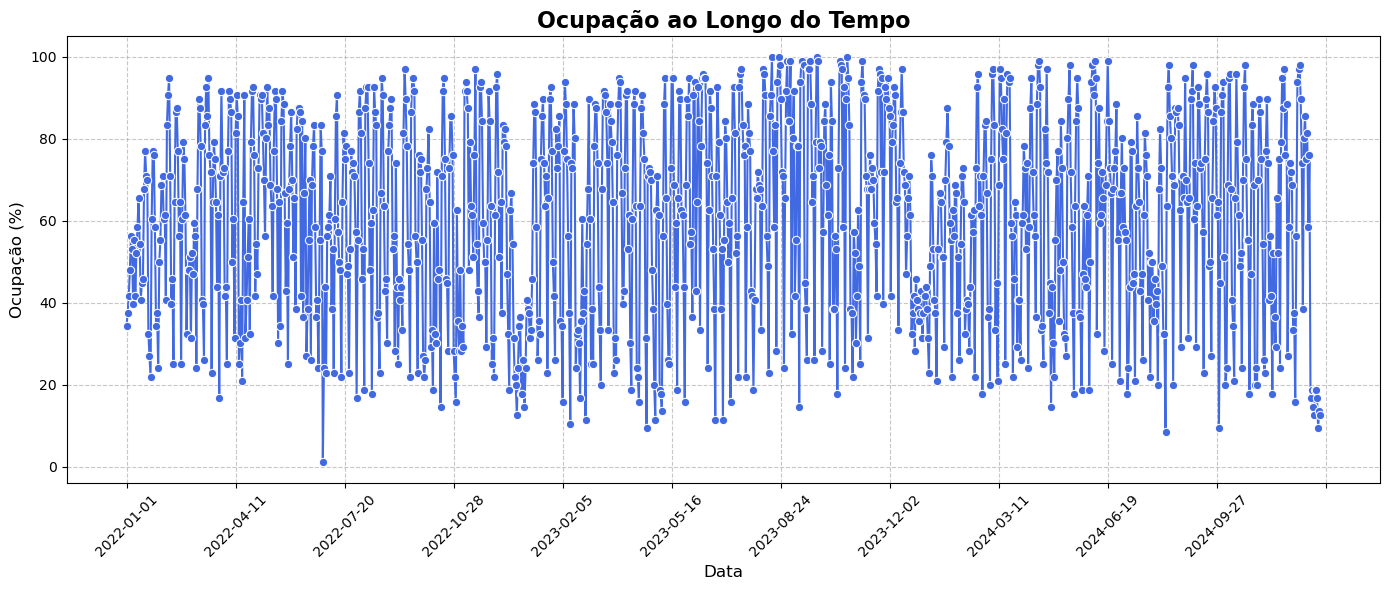

In [27]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='data', y='occ', marker='o', color='royalblue', linewidth=1.5)
plt.title('Ocupação ao Longo do Tempo', fontsize=16, weight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Ocupação (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=15))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Tendências de ADR:

Utilizaremos a decomposição da série temporal.

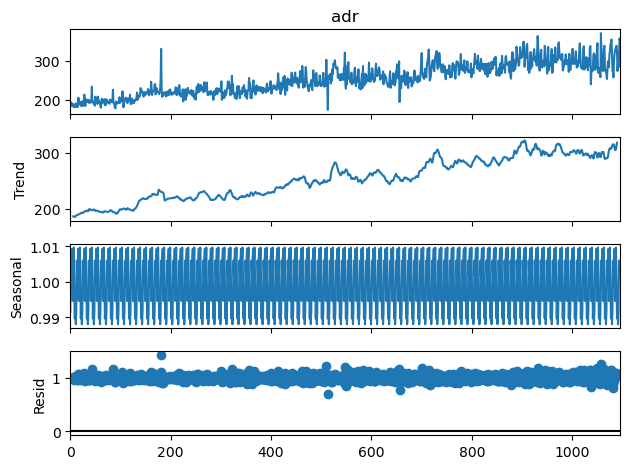

In [30]:
dec_adr = sm.tsa.seasonal_decompose(df['adr'],period = 12, model = 'multiplicative').plot()
plt.show()

Não olharemos para uma tendência de ocupação devido a grande oscilação do KPI.

## Modelo de ML:

Passando os dias da semana para números de 0 - 6, sendo: 
- 0: Domingo
- 1: Segunda
- 2: Terça
- 3: Quarta
- 4: Quinta
- 5: Sexta
- 6: Sábado

In [34]:
df['dia_semana'] = df['dia_semana'].replace({'Domingo': 0, 'Segunda': 1, 'Terça': 2, 'Quarta': 3, 'Quinta': 4, 'Sexta': 5, 'Sábado': 6})
df.head(1)

,data,dia_semana,adr,occ
0,2022-01-01,6,186.612727,34.375


Vamos também adicionar algumas features para ajudar nosso modelo, como informar se é ou não final de semana ou dia de semana.

In [36]:
df['fds'] = df['dia_semana'].isin([5, 6, 0]).astype(int)
df.head(1)

,data,dia_semana,adr,occ,fds
0,2022-01-01,6,186.612727,34.375,1


In [37]:
df['dia_de_semana'] = df['dia_semana'].isin([1, 2, 3, 4]).astype(int)
df.head(1)

,data,dia_semana,adr,occ,fds,dia_de_semana
0,2022-01-01,6,186.612727,34.375,1,0


In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [39]:
X_occ = df[['data','dia_semana', 'fds', 'dia_de_semana']]  # Features para a previsão de ocupação
y_occ = df['occ']  # Target para a previsão de ocupação

In [40]:
X_adr = df[['data','dia_semana', 'fds', 'dia_de_semana']]  # Features para a previsão de ADR
y_adr = df['adr']  # Target para a previsão de ADR

Trenio e teste:

In [42]:
X_train_occ, X_test_occ, y_train_occ, y_test_occ = train_test_split(X_occ, y_occ, test_size=0.2, random_state=42)
X_train_adr, X_test_adr, y_train_adr, y_test_adr = train_test_split(X_adr, y_adr, test_size=0.2, random_state=42)

Modelo OCC:

In [44]:
X_train_occ = X_train_occ.select_dtypes(include=[np.number])
X_test_occ = X_test_occ.select_dtypes(include=[np.number])

In [45]:
model_occ = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
model_occ.fit(X_train_occ, y_train_occ)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

Modelo ADR:

In [47]:
X_train_adr = X_train_adr.select_dtypes(include=[np.number])
X_test_adr = X_test_adr.select_dtypes(include=[np.number])

In [48]:
model_adr = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
model_adr.fit(X_train_adr, y_train_adr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

Previsão de OCC:

In [50]:
y_pred_occ = model_occ.predict(X_test_occ)
rmse_occ = np.sqrt(mean_squared_error(y_test_occ, y_pred_occ))
rmse_occ

18.168904154563904

Previsão de ADR:

In [52]:
y_pred_adr = model_adr.predict(X_test_adr)
rmse_adr = np.sqrt(mean_squared_error(y_test_adr, y_pred_adr))
rmse_adr

41.029465408596536

Melhorando nosso erro:

In [54]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_occ, X_train_occ, y_train_occ, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())

Cross-validated RMSE: 17.220554020713447


In [55]:
scores = cross_val_score(model_adr, X_train_adr, y_train_adr, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())

Cross-validated RMSE: 39.21882904946231


In [98]:
df_comparacao_occ = pd.DataFrame({'Real': y_test_occ, 'Previsto': y_pred_occ_final})
df_comparacao_adr = pd.DataFrame({'Real': y_test_adr, 'Previsto': y_pred_adr_final})

print("Comparação de Ocupação (OCC):")
print(df_comparacao_occ.head())

print("Comparação de ADR:")
print(df_comparacao_adr.head())

Comparação de Ocupação (OCC):
          Real   Previsto
44   64.583333  66.848969
568  21.875000  26.041744
56   47.916667  52.477013
636  79.166667  50.633366
486  62.500000  81.292259
Comparação de ADR:
           Real    Previsto
44   194.737581  247.813095
568  257.889048  251.501297
56   200.908261  266.115265
636  252.733684  255.959946
486  256.629000  252.151566
